In [1]:
import pyspark as ps
import pandas as pd

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('books')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[4] appName=books>

In [4]:
spark

In [5]:
from pyspark.sql.types import *

# create a schema of your own
schema = StructType( [
    StructField('user',     StringType(), True),
    StructField('book',   StringType(),  True),
    StructField('rating',  StringType(), True),
])

In [12]:
rdd = (
    sc.textFile('data/cleantrain.csv')
        .map(lambda x : x.split(","))
            )

In [21]:
rdd2 = (
    sc.textFile('data/cleantest.csv')
        .map(lambda x : x.split(","))
            )

In [22]:
df = spark.createDataFrame(rdd,schema)
df2 = spark.createDataFrame(rdd2,schema)

In [14]:
df.printSchema()

root
 |-- user: string (nullable = true)
 |-- book: string (nullable = true)
 |-- rating: string (nullable = true)



In [15]:
rdd.take(5)

[['277195', '105', '5.0'],
 ['277195', '953', '5.0'],
 ['277195', '3958', '5.0'],
 ['277195', '4091', '5.0'],
 ['277195', '4105', '5.0']]

In [23]:
train = df.select(df.user.cast('int'), df.book.cast('int'),df.rating.cast('float'))
test = df2.select(df2.user.cast('int'), df2.book.cast('int'),df2.rating.cast('float'))

In [19]:
train.take(5)

[Row(user=277195, book=105, rating=5.0),
 Row(user=277195, book=953, rating=5.0),
 Row(user=277195, book=3958, rating=5.0),
 Row(user=277195, book=4091, rating=5.0),
 Row(user=277195, book=4105, rating=5.0)]

In [17]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='book',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=50) 

In [13]:
# train, test = df2.randomSplit([0.8, 0.2], seed=427471138)

In [20]:
recommender = als_model.fit(train)

In [24]:
predictions = recommender.transform(test)

In [25]:
recommender.transform(test).show()

+------+----+------+----------+
|  user|book|rating|prediction|
+------+----+------+----------+
|204864| 148|  null| 4.4853373|
| 60244| 148|  null| 4.2379265|
|271176| 148|  null|   3.95103|
|170518| 148|  null| 3.4415097|
| 78834| 148|  null|  4.349413|
|258534| 148|  null| 4.5861483|
| 23768| 148|  null| 3.3894906|
| 91832| 148|  null| 2.8064253|
|161752| 148|  null| 3.6379368|
|152249| 148|  null|   4.38995|
|255078| 148|  null| 3.4349988|
|130571| 148|  null| 3.8845785|
|230249| 148|  null|  3.452651|
| 37512| 148|  null| 2.3121912|
|219546| 148|  null|  3.428132|
|225763| 148|  null|  2.439271|
|184465| 148|  null| 3.8936455|
|260897| 148|  null| 3.6483135|
|183995| 148|  null|  4.653163|
|122506| 148|  null|  3.224774|
+------+----+------+----------+
only showing top 20 rows



In [17]:
predictions.show()

+-------+----+------+----------+
|   user|book|rating|prediction|
+-------+----+------+----------+
|1757721| 148|   4.0| 3.4146252|
| 914583| 463|   4.0|       NaN|
| 974278| 471|   2.0|       NaN|
|1445208| 471|   5.0|       NaN|
| 209701| 471|   5.0|       NaN|
| 684443| 471|   5.0| 3.8172643|
| 767181| 471|   5.0|       NaN|
| 920109| 471|   5.0|       NaN|
|  57858| 471|   5.0|       NaN|
| 991466| 471|   5.0|  4.546288|
|  26898| 471|   3.0| 3.2543664|
| 102172| 471|   5.0|  4.538481|
|1629879| 471|   5.0|       NaN|
| 772884| 471|   5.0|       NaN|
|1714348| 471|   1.0|       NaN|
|1415761| 471|   5.0| 2.7978282|
| 355817| 471|   5.0|       NaN|
|1480463| 471|   2.0|       NaN|
|  39862| 471|   4.0| 4.3883767|
|1420991| 471|   5.0|       NaN|
+-------+----+------+----------+
only showing top 20 rows



In [26]:
pdf = predictions.toPandas()

In [27]:
pdf.head()

,user,book,rating,prediction
0,204864,148,NaN,4.485337
1,60244,148,NaN,4.237926
2,271176,148,NaN,3.951030
3,170518,148,NaN,3.441510
4,78834,148,NaN,4.349413


In [28]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155905 entries, 0 to 155904
Data columns (total 4 columns):
user          155905 non-null int32
book          155905 non-null int32
rating        0 non-null float32
prediction    151525 non-null float32
dtypes: float32(2), int32(2)
memory usage: 2.4 MB


In [29]:
from scipy.sparse import csr_matrix
ratings_as_mat = csr_matrix((pdf.rating, 
        ((pdf.user), (pdf.book))))

In [30]:
def bookaverage(x):
        return ratings_as_mat[:,x].sum()/len(ratings_as_mat[:,x].nonzero()[0])
    
def model_results(indf):
    df = indf.copy()
    dfna = df[df.prediction.isna()]
    dfnotna = df[df.prediction.notna()]
    dfna.prediction = dfna.book.apply(lambda x: bookaverage(x))
    out = pd.concat((dfnotna,dfna))
    out.sort_index(inplace=True)
    return out

In [31]:
results = model_results(pdf)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [39]:
# results.to_pickle('ALSresults2.pkl')

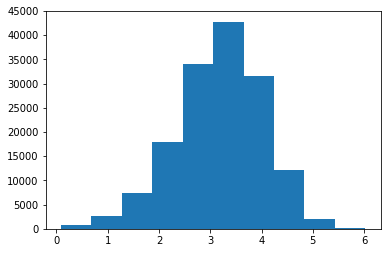

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results.prediction);